<a href="https://colab.research.google.com/github/shintyawa/VisionTransformer-Comparison/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# ===== 1) Instalasi Dependensi =====
!pip -q install torch torchvision albumentations timm torchinfo pandas pillow scikit-learn matplotlib

In [16]:
# ====== DOWNLOAD & UNZIP DATASET DARI GOOGLE DRIVE ======
file_id = "1c2gJEm9-54JVrJ0q6cqwECHA9wb0mUOs"
zip_name = "dataset.zip"

import os, zipfile, glob

# Download hanya jika file belum ada
if not os.path.exists(zip_name):
    !gdown --id {file_id} -O {zip_name}

# Ekstrak zip ke current directory
with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall(".")

print("Selesai ekstrak. Daftar folder tingkat atas:")
for p in sorted([p for p in os.listdir(".") if os.path.isdir(p)]):
    print(" -", p)

Selesai ekstrak. Daftar folder tingkat atas:
 - .config
 - __MACOSX
 - sample_data
 - test
 - train


In [17]:
# ===== 1) Import & Konfigurasi Global Lanjutan =====
import os, random, time, json, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import timm
from timm.scheduler.cosine_lr import CosineLRScheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2
ALB_OK = True

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan Device: {DEVICE}")


Menggunakan Device: cuda


# Setup konfigurasi

In [ ]:
# ===== 3) Konstanta & Path =====
CLASS_NAMES = ["nasi_goreng", "rendang", "soto_ayam", "bakso", "gado_gado"]

DATA_DIR = Path(".")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"
TRAIN_CSV = DATA_DIR / "train.csv"
TEST_CSV  = DATA_DIR / "test.csv"

# Label mapping
label2id = {c:i for i, c in enumerate(CLASS_NAMES)}
id2label = {v:k for k,v in label2id.items()}
NUM_CLASSES = len(CLASS_NAMES)

# Hyperparams Default
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 2
WEIGHT_DECAY = 1e-4
LR = 1e-4 # Learning rate untuk Fine-tuning
EPOCHS = 10
ARCH = "vit_small_patch16_224" # swin_base_patch4_window7_224 (untuk swin transformer)

# History penyimpanan hasil eksperimen
EXPERIMENT_HISTORY = []


# Load Dataset

   filename      label
0  0001.jpg  gado_gado
1  0002.jpg  gado_gado
2  0003.jpg    rendang
3  0004.jpg      bakso
4  0005.jpg      bakso

Jumlah data: 1108
Kelas unik: ['gado_gado' 'rendang' 'bakso' 'soto_ayam' 'nasi_goreng']


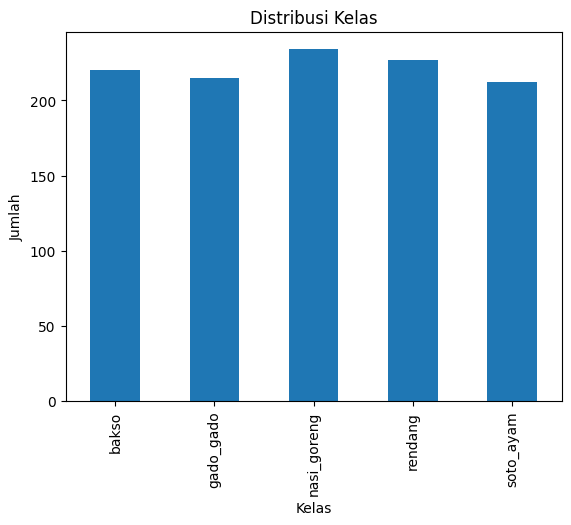

In [19]:
def safe_read_train():
    if TRAIN_CSV.exists():
        df = pd.read_csv(TRAIN_CSV)
        assert set(["filename","label"]).issubset(df.columns), "train.csv harus punya kolom filename,label"
        return df
    return None

df_train = safe_read_train()
if df_train is not None:
    print(df_train.head())
    print("\nJumlah data:", len(df_train))
    print("Kelas unik:", df_train['label'].unique())

    # Distribusi kelas
    ax = df_train['label'].value_counts().sort_index().plot(kind='bar', title='Distribusi Kelas')
    ax.set_xlabel("Kelas"); ax.set_ylabel("Jumlah")
    plt.show()
else:
    print("train.csv tidak ditemukan. Melewati EDA (ini normal di lingkungan panitia saat hanya inferensi).")


# Preprocessing & Augmentasi

Pelatihan dan Validasi/Uji menggunakan Albumentations, di mana kedua mode tersebut wajib melakukan Resize menjadi 224 × 224 piksel dan Normalize menggunakan mean dan std standar ImageNet untuk stabilitas model, diikuti oleh ToTensorV2 yang mengkonversi gambar menjadi tensor PyTorch. Khusus pada mode Pelatihan, serangkaian augmentasi diterapkan untuk mencegah overfitting dan meningkatkan robustnes model, meliputi HorizontalFlip (p=0.5), ShiftScaleRotate (shift 0.02, scale 0.1, rotate 15) untuk variasi geometris, dan ColorJitter (p=0.3) untuk variasi pencahayaan dan warna.


In [20]:
def build_transforms(img_size=IMG_SIZE, is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.ColorJitter(p=0.3),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2(),
        ])

class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / row['filename']
        image = Image.open(img_path).convert("RGB")
        np_img = np.array(image)

        if self.transforms is not None:
            # Albumentations bekerja dengan NumPy array
            np_img = self.transforms(image=np_img)["image"]

        if self.is_test:
            return np_img, row['filename']
        else:
            label = label2id[row['label']]
            return np_img, label

In [21]:
def build_dataloaders(df, test_size=0.1, batch_size=BATCH_SIZE):
    tr_df, val_df = train_test_split(
        df, test_size=test_size, random_state=SEED, stratify=df['label']
    )
    tfm_tr = build_transforms(IMG_SIZE, is_train=True)
    tfm_val = build_transforms(IMG_SIZE, is_train=False)

    ds_tr = ImageDataset(tr_df, TRAIN_DIR, transforms=tfm_tr, is_test=False)
    ds_val = ImageDataset(val_df, TRAIN_DIR, transforms=tfm_val, is_test=False)

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    return dl_tr, dl_val, tr_df, val_df

# Load Data
df_train = safe_read_train()
if df_train is not None and TRAIN_DIR.exists():
    dl_tr, dl_val, tr_df, val_df = build_dataloaders(df_train, test_size=0.1, batch_size=BATCH_SIZE)
    dls_ready = True
    print(f"Data siap. Train: {len(tr_df)} | Val: {len(val_df)}")
else:
    dls_ready = False
    print("Lewati: build dataloaders (train.csv atau folder train/ tidak ada).")

Data siap. Train: 997 | Val: 111


In [22]:
def build_model(arch=ARCH, num_classes=len(CLASS_NAMES), pretrained=True):
    model = timm.create_model(arch, pretrained=pretrained, num_classes=num_classes)
    return model

model = build_model().to(DEVICE)

try:
    print(summary(model, input_size=(1, 3, IMG_SIZE, IMG_SIZE)))
except Exception as e:
    print("Gagal menampilkan summary:", e)


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 5]                    76,032
├─PatchEmbed: 1-1                        [1, 196, 384]             --
│    └─Conv2d: 2-1                       [1, 384, 14, 14]          295,296
│    └─Identity: 2-2                     [1, 196, 384]             --
├─Dropout: 1-2                           [1, 197, 384]             --
├─Identity: 1-3                          [1, 197, 384]             --
├─Identity: 1-4                          [1, 197, 384]             --
├─Sequential: 1-5                        [1, 197, 384]             --
│    └─Block: 2-3                        [1, 197, 384]             --
│    │    └─LayerNorm: 3-1               [1, 197, 384]             768
│    │    └─Attention: 3-2               [1, 197, 384]             591,360
│    │    └─Identity: 3-3                [1, 197, 384]             --
│    │    └─Identity: 3-4                [1, 197, 384]             --


Dalam proses pelatihan ini, kami menggunakan Optimizer AdamW karena, berdasarkan penelitian, decoupled weight decay yang dimilikinya memungkinkan regularisasi L2 bekerja dengan benar pada optimizer adaptif, menghasilkan training yang lebih stabil dan generalisasi yang lebih baik dibandingkan dengan L2 pada Adam klasik. Selain itu, kami juga menerapkan CosineLRScheduler (dengan warmup) untuk mengatur learning rate. Cosine scheduler menurunkan learning rate secara bertahap dan halus mengikuti kurva kosinus. Strategi ini terbukti efektif dalam membuat proses training lebih efisien, menghindari terjebak dalam local minima, dan membantu model mencapai konvergensi yang lebih cepat serta performa akhir yang lebih optimal. Kombinasi AdamW dengan Cosine Annealing dan warmup telah menjadi resep standar dalam melatih arsitektur visi modern seperti ViT, yang secara empiris meningkatkan stabilitas dan akurasi pelatihan secara signifikan.

In [36]:
DO_TRAIN = True

def train_one_epoch(model, dl, criterion, optimizer):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for x, y in dl:
        # Konversi y menjadi Long Tensor (diperlukan untuk CrossEntropyLoss)
        y = torch.tensor(y, dtype=torch.long)
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return epoch_loss/total, correct/total

@torch.no_grad()
def evaluate(model, dl, criterion):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    all_y, all_p = [], []
    for x, y in dl:
        # Konversi y menjadi Long Tensor
        y = torch.tensor(y, dtype=torch.long)
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        loss = criterion(logits, y)

        epoch_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_y.extend(y.detach().cpu().numpy().tolist())
        all_p.extend(preds.detach().cpu().numpy().tolist())

    acc = correct/total if total>0 else 0.0
    return epoch_loss/total if total>0 else 0.0, acc, np.array(all_y), np.array(all_p)

# Menggunakan logika asli dengan perbaikan logging
DO_TRAIN = True # Asumsi ini didefinisikan atau diatur ke True
dls_ready = True # Asumsi dataloaders siap

if DO_TRAIN and dls_ready:
    print("\nMemulai Pelatihan...")

    # Inisialisasi Kriteria, Optimizer, dan Scheduler
    criterion = nn.CrossEntropyLoss()
    weight_decay = WEIGHT_DECAY
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=weight_decay)

    base_lr = optimizer.param_groups[0]['lr']
    scheduler = CosineLRScheduler(
        optimizer,
        t_initial=EPOCHS,
        lr_min=1e-6,
        warmup_t=5,
        warmup_lr_init=base_lr * 0.01,
        t_in_epochs=True,
    )

    best_acc = 0.0
    best_path = "model.pth"

    train_hist, val_hist = [], []

    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, dl_tr, criterion, optimizer)
        val_loss, val_acc, y_true, y_pred = evaluate(model, dl_val, criterion)

        # Step the scheduler after each epoch
        scheduler.step(epoch)
        current_lr = optimizer.param_groups[0]['lr']

        train_hist.append((epoch, tr_loss, tr_acc))
        val_hist.append((epoch, val_loss, val_acc))

        # --- PERBAIKAN LOGGING DENGAN flush=True ---
        print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | lr={current_lr:.6f}", flush=True)

        # simpan terbaik
        if val_acc > best_acc:
            best_acc = val_acc
            # Save only the state dictionary
            torch.save(model.state_dict(), best_path)
            print(f" Model disimpan pada epoch {epoch} (Val Acc: {best_acc:.4f}) ***")


    # tampilkan ringkas report val terakhir
    print("\nPelatihan Selesai.")
    try:
        # Muat kembali model terbaik sebelum mencetak laporan
        model.load_state_dict(torch.load(best_path, map_location=DEVICE))
        _, _, final_y_true, final_y_pred = evaluate(model, dl_val, criterion)

        print("\nValidation classification report (Best Model):")
        print(classification_report(final_y_true, final_y_pred, target_names=CLASS_NAMES))
        print("Confusion matrix:")
        print(confusion_matrix(final_y_true, final_y_pred))
    except Exception as e:
        print(f"Gagal membuat report: {e}")



Memulai Pelatihan...
Epoch 01/10 | train_loss=0.0768 acc=0.9739 | val_loss=0.0832 acc=0.9730 | lr=0.000021
*** Model disimpan pada epoch 1 (Val Acc: 0.9730) ***
Epoch 02/10 | train_loss=0.0313 acc=0.9940 | val_loss=0.0751 acc=0.9730 | lr=0.000041
Epoch 03/10 | train_loss=0.0197 acc=0.9930 | val_loss=0.0725 acc=0.9820 | lr=0.000060
*** Model disimpan pada epoch 3 (Val Acc: 0.9820) ***
Epoch 04/10 | train_loss=0.0452 acc=0.9870 | val_loss=0.1340 acc=0.9730 | lr=0.000080
Epoch 05/10 | train_loss=0.1006 acc=0.9669 | val_loss=0.1407 acc=0.9640 | lr=0.000051
Epoch 06/10 | train_loss=0.0512 acc=0.9840 | val_loss=0.0497 acc=0.9730 | lr=0.000035
Epoch 07/10 | train_loss=0.0094 acc=0.9960 | val_loss=0.0965 acc=0.9730 | lr=0.000021
Epoch 08/10 | train_loss=0.0035 acc=1.0000 | val_loss=0.0862 acc=0.9640 | lr=0.000010
Epoch 09/10 | train_loss=0.0047 acc=0.9980 | val_loss=0.0489 acc=0.9910 | lr=0.000003
*** Model disimpan pada epoch 9 (Val Acc: 0.9910) ***
Epoch 10/10 | train_loss=0.0041 acc=0.9980

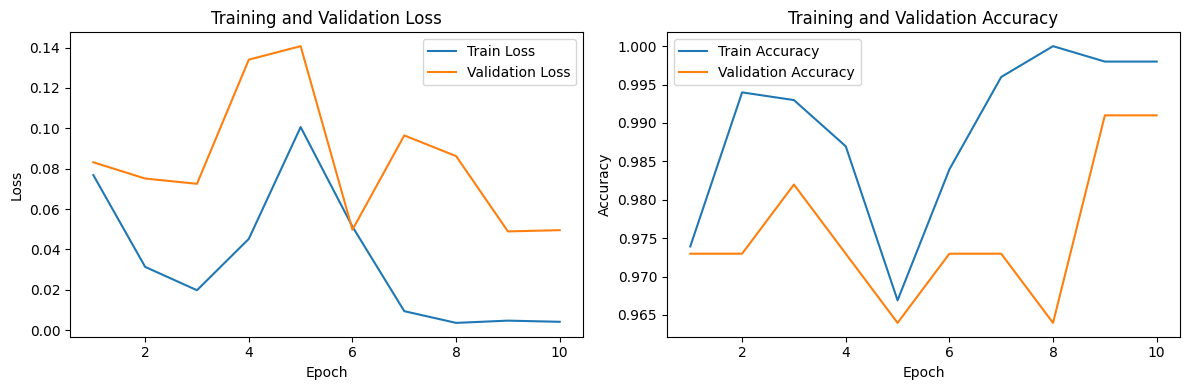

In [39]:
# Plotting training and validation history (dipertahankan dari kode awal)
train_epochs, train_losses, train_accs = zip(*train_hist)
val_epochs, val_losses, val_accs = zip(*val_hist)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, label='Train Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_epochs, train_accs, label='Train Accuracy')
plt.plot(val_epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Model yang dilatih berhasil mencapai performa luar biasa dengan akurasi validasi tertinggi 99.10% (Epoch 9). Meskipun kurva pembelajaran menunjukkan volatilitas kerugian validasi antara Epoch 4 hingga Epoch 7—seperti terlihat pada fluktuasi Validation Loss— model berhasil pulih dan mencapai konvergensi yang stabil berkat penggunaan CosineLRScheduler dan optimizer AdamW. Secara keseluruhan, model menunjukkan generalisasi yang sangat baik dengan kerugian pelatihan dan validasi yang berakhir pada nilai sangat rendah dan berdekatan, mengindikasikan overfitting minimal. Classification Report memvalidasi hasil ini, menunjukkan akurasi, precision, dan recall global sebesar 0.99, dengan sebagian besar kelas (nasi_goreng, bakso, gado_gado) mencapai skor sempurna 1.00, sementara kelas soto_ayam dan rendang hanya menunjukkan sedikit misclassification yang sangat minimal.